In [1]:
%matplotlib inline
from pycocotools.coco import COCO
from pycocotools import mask as cocomask
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import os
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

## Configuration Variables

In [2]:
data_directory = "/media/HDD_3TB_2/bhalaji/challenges/aicrowd/food_recognition_challenge/data"
annotation_file_template = "{}/{}/annotation{}.json"

TRAIN_IMAGES_DIRECTORY = os.path.join(data_directory, "train/images")
TRAIN_ANNOTATIONS_PATH = os.path.join(data_directory, "train/annotations.json")

VAL_IMAGES_DIRECTORY = os.path.join(data_directory, "val/images")
VAL_ANNOTATIONS_PATH = os.path.join(data_directory, "val/annotations.json")


## Parsing the annotations 

This dataset releases the annotations in the [MS COCO format](http://cocodataset.org/#format). Please read up more about it at : [http://cocodataset.org/#format](http://cocodataset.org/#format).


In [3]:
coco = COCO(VAL_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!



The dataset has labels for 61 food categories,their corresponding `category_id`. 

In [12]:
category_ids = coco.loadCats(coco.getCatIds())
category_names = [_["name"] for _ in category_ids]
", ".join(category_names)


'water, pear, egg, grapes, butter, bread-white, jam, bread-whole-wheat, apple, tea-green, white-coffee-with-caffeine, tea-black, mixed-salad-chopped-without-sauce, cheese, tomato-sauce, pasta-spaghetti, carrot, onion, beef-cut-into-stripes-only-meat, rice-noodles-vermicelli, salad-leaf-salad-green, bread-grain, espresso-with-caffeine, banana, mixed-vegetables, bread-wholemeal, savoury-puff-pastry, wine-white, dried-meat, fresh-cheese, red-radish, hard-cheese, ham-raw, bread-fruit, oil-vinegar-salad-dressing, tomato, cauliflower, potato-gnocchi, wine-red, sauce-cream, pasta-linguini-parpadelle-tagliatelle, french-beans, almonds, dark-chocolate, mandarine, semi-hard-cheese, croissant, sushi, berries, biscuits, thickened-cream-35, corn, celeriac, alfa-sprouts, chickpeas, leaf-spinach, rice, chocolate-cookies, pineapple, tart, coffee-with-caffeine, focaccia, pizza-with-vegetables-baked, soup-vegetable, bread-toast, potatoes-steamed, spaetzle, frying-sausage, lasagne-meat-prepared, boisson-

## Collecting and Visualizing Images

In [13]:
# This generates a list of all `image_ids` available in the dataset
image_ids = coco.getImgIds()

In [14]:
# For this demonstration, we will randomly choose an image_id
random_image_id = random.choice(image_ids)

In [15]:
# Now that we have an image_id, we can load its corresponding object by doing :
img = coco.loadImgs(random_image_id)[0]

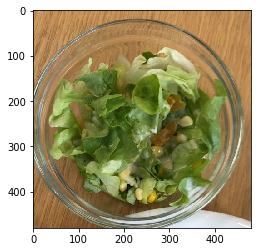

In [16]:
image_path = os.path.join(VAL_IMAGES_DIRECTORY, img["file_name"])
I = io.imread(image_path)
plt.imshow(I)
plt.show()

## Understanding Annotations

Given a **numeric** `image_id` for an image, then we can load the corresponding annotations for the image by doing : 

In [9]:
annotation_ids = coco.getAnnIds(imgIds=img['id'])
annotations = coco.loadAnns(annotation_ids)

In [10]:
print(annotations)

[{'id': 119062, 'image_id': 77768, 'category_id': 2269, 'segmentation': [[122.85000000000001, 71.955, 93.60000000000001, 33.345, 49.725, 46.800000000000004, 19.305, 96.52499999999999, 8.190000000000001, 172.57500000000002, 23.400000000000002, 222.29999999999998, 81.89999999999999, 231.66, 132.795, 229.32, 154.44, 218.79000000000002, 176.08499999999998, 214.695, 204.16500000000002, 221.715, 223.47, 225.81, 226.98, 53.235, 200.655, 49.14, 189.54000000000002, 76.635, 129.285, 74.88]], 'area': 34435.0, 'bbox': [8.190000000000001, 8.190000000000001, 223.47, 218.79], 'iscrowd': 0}]


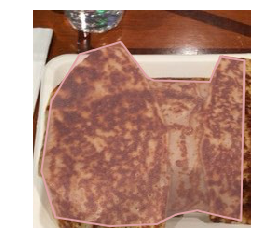

In [11]:
# load and render the image
plt.imshow(I); plt.axis('off')
# Render annotations on top of the image
coco.showAnns(annotations)

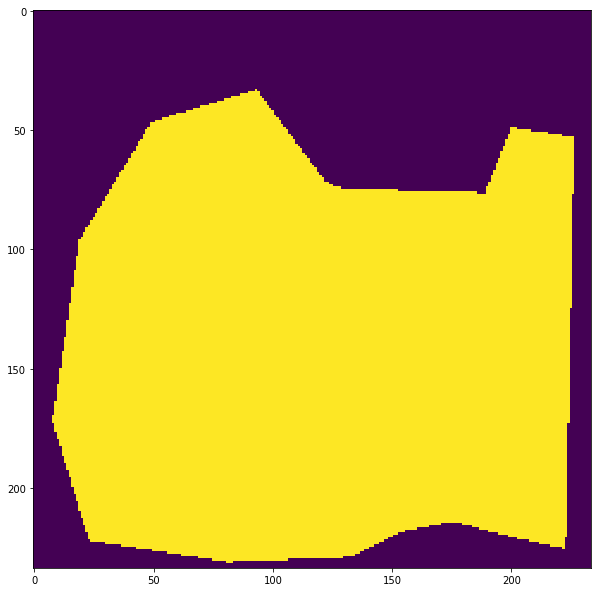

In [12]:
pylab.rcParams['figure.figsize'] = (10, 40.0)
for _idx, annotation in enumerate(annotations):
    plt.subplot(len(annotations), 1, _idx+1)
    rle = cocomask.frPyObjects(annotation['segmentation'], img['height'], img['width'])
    m = cocomask.decode(rle)
    # m.shape has a shape of (300, 300, 1)
    # so we first convert it to a shape of (300, 300)
    m = m.reshape((img['height'], img['width']))
    plt.imshow(m)
plt.show()

# Evaluate predictions

In [4]:
import json
from cocoeval import COCOeval
from pycocotools import mask as cocomask

In [5]:
submission_file = json.loads(open("../predictions.json").read())

In [6]:
coco_pred = COCO(VAL_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [7]:
results = coco_pred.loadRes(submission_file)

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


In [8]:
cocoEval = COCOeval(coco_pred, results, 'segm')

In [9]:
cocoEval.evaluate()
cocoEval.accumulate()

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=2.21s).
Accumulating evaluation results...
DONE (t=0.69s).


In [10]:
average_precision = cocoEval._summarize(ap=1, iouThr=0.5, areaRng="all", maxDets=100)
average_recall = cocoEval._summarize(ap=0, iouThr=0.5, areaRng="all", maxDets=100)
print("Average Precision : {} || Average Recall : {}".format(average_precision, average_recall))

 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
Average Precision : 4.6879687968796877e-05 || Average Recall : 0.0005411255411255411


In [17]:
annotation_ids = coco_pred.getAnnIds(imgIds=img['id'])

annotations = coco_pred.loadAnns(annotation_ids)

In [18]:
print(annotations)

[{'id': 67663, 'image_id': 36932, 'category_id': 1108, 'segmentation': {'size': [480, 480], 'counts': b'UTn26c>8G:F9G9O1O1O100O1O1O100O1O100O1O1O100O1O100O1O1O100O2N1O10O00010O0000010O000010O000010O0000010O000010O0000010O0000010O01O1O100O1O1O1O1O1N3N1N2O1N2O1N2O1N2N3N1N2O1N2O1N2O1N2G9O2M2N2O1N2N2N2OUke2'}, 'area': 4523.0, 'bbox': [199.8, 199.8, 211.8, 95.99999999999994], 'iscrowd': 0, 'ignore': 0, '_ignore': 1}, {'id': 66332, 'image_id': 36932, 'category_id': 1040, 'segmentation': {'size': [480, 480], 'counts': b'fi72h>7I8H7I7J6I7I7I8H7I7I7I7I7I8H7I7I7J6I7I8H7I7I7I7I7I8H7I7I7K5O1N3N1N2O1N2O1N3N1N2O1N2O1N3N1N2O1N2O1N3N1N2O1N2O1N3N1O1N2O1N2O2M2O1N2O0O2O0O2O0O2O1N101N101N101N101N101N101N101N2O0O2O0O2O0O2O0O2O0O2O0O2O1N101O0O2O0O2O0O2O0O2O0O2O0O2O1N101N101N101N101N101N101N101N2O0O2O0O2O0O2O0O2O0O2O0O2O0O2O1N101O0O2O0O2O0O2O0O2O0O2O0O2O1N101N101N101N101N101N10O0100O10O0100O10O0100O10O0100O010O100O010001O0O10001O0O10001N1000001N1000001O0000001N1000001O000000001N1000001O0000001O0O10001O000000

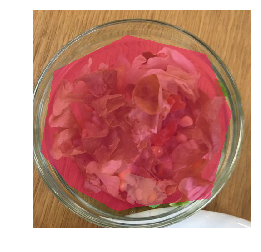

In [19]:
plt.imshow(I) 
plt.axis('off')

coco_pred.showAnns(annotations)

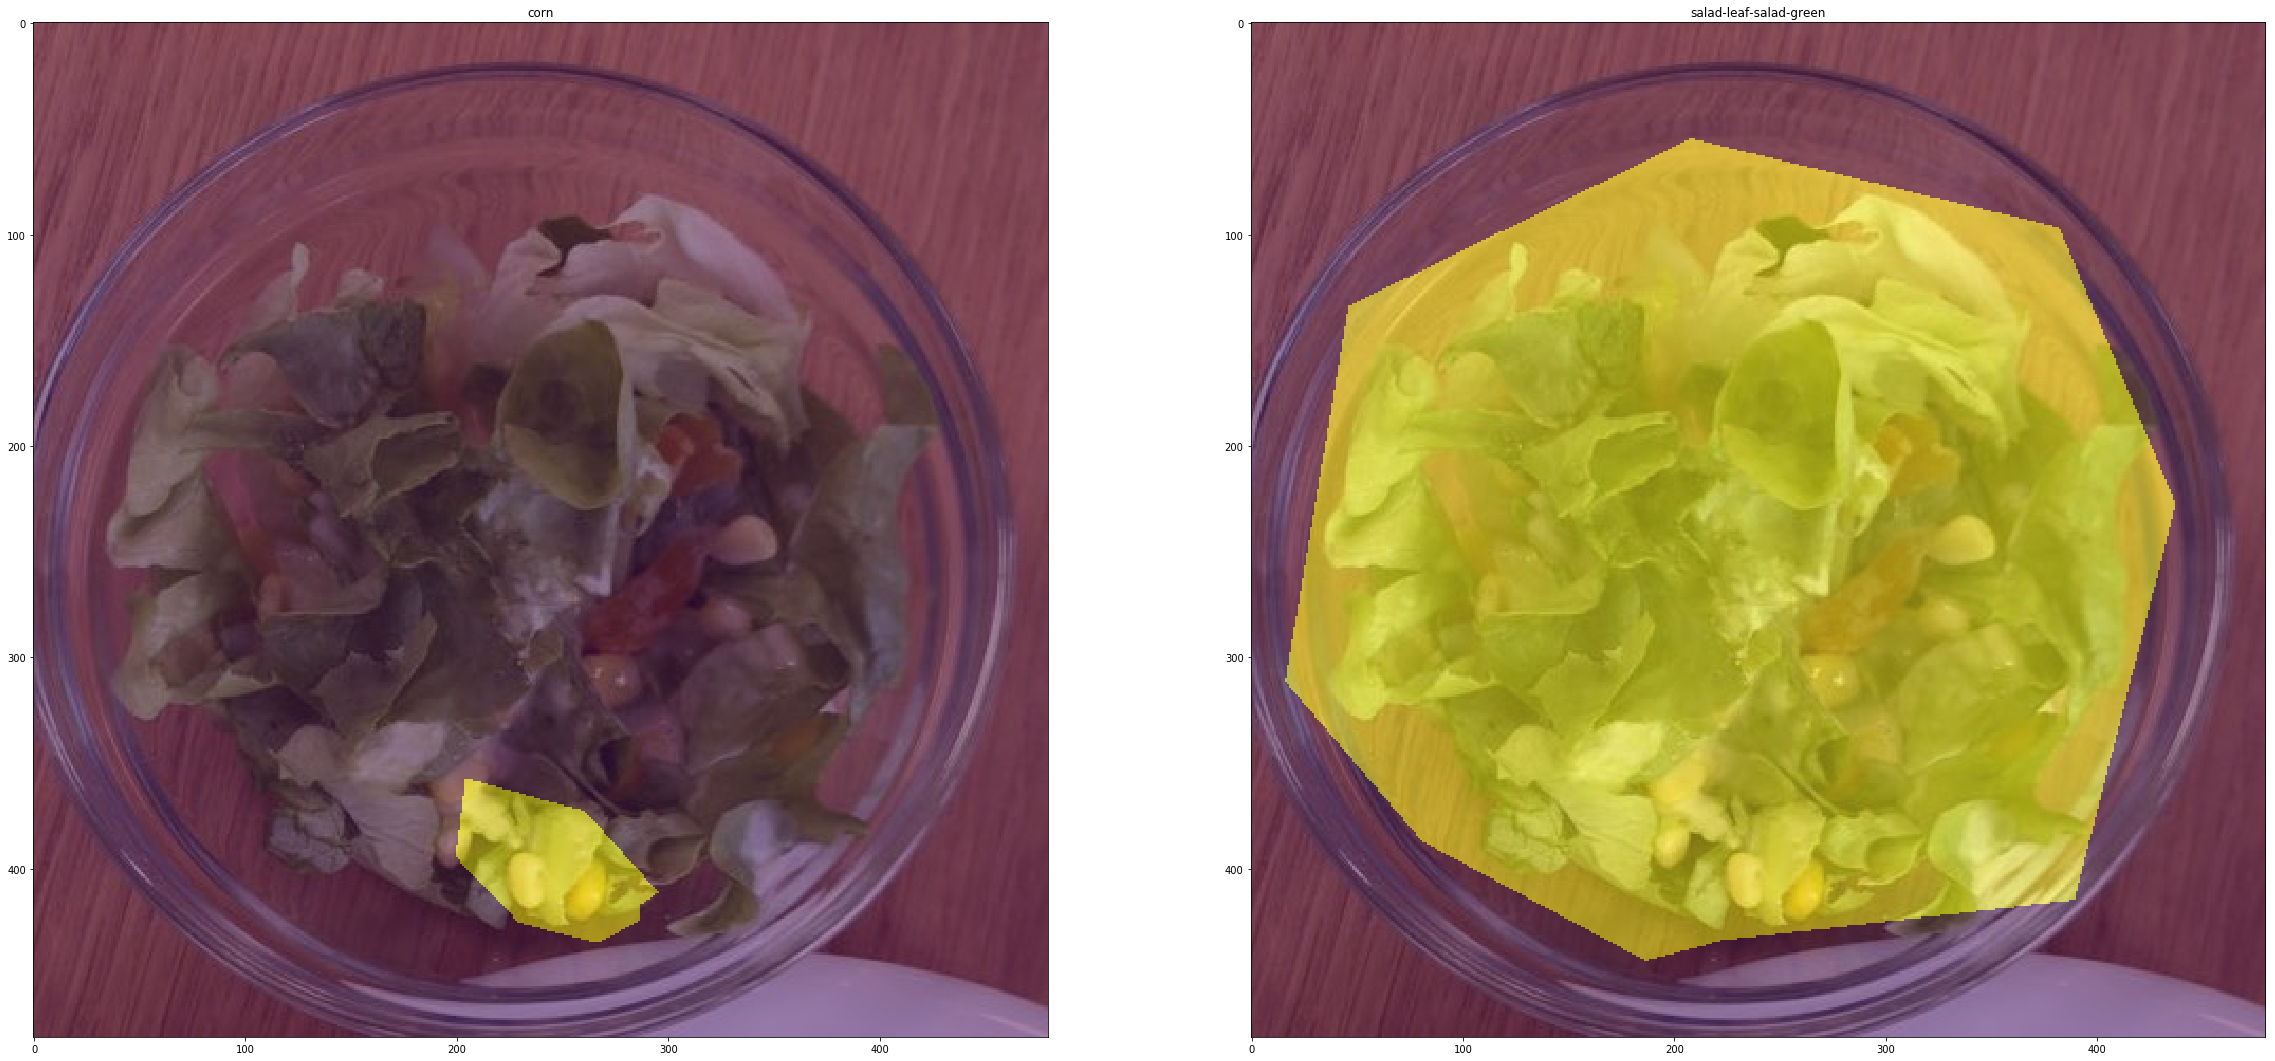

In [20]:
pylab.rcParams['figure.figsize'] = (40, 40)

fig, axes = plt.subplots(1, len(annotations), squeeze=False)

for _idx, annotation in enumerate(annotations):
    ann_segmentation = annotations[_idx]['segmentation']
    m = cocomask.decode(ann_segmentation)

    m = m.reshape((img['height'], img['width']))
    
    axes[0][_idx].imshow(I)
    axes[0][_idx].imshow(m, alpha=0.5)
    axes[0][_idx].set_title(next(item for item in category_ids if item["id"] == annotations[_idx]['category_id'])['name'])

plt.show()